In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import gzip
import pickle

import os
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import re
import datetime
import pickle
import tensorflow as tf

from tensorflow.keras.callbacks import ModelCheckpoint
%load_ext tensorboard
from gensim.models import Word2Vec
from gensim.models import FastText
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, GRU,LSTM,concatenate,Flatten,GlobalMaxPooling1D,GlobalAveragePooling1D
from tensorflow.keras.models import Model
import nltk.translate.bleu_score as bleu

tf.compat.v1.enable_eager_execution()

tf.executing_eagerly()

True

Fixing Random seed

In [2]:
import random as rn

##fixing numpy RS
np.random.seed(1)

##fixing tensorflow RS
tf.random.set_seed(2)
#tf.set_random_seed(2)

##python RS
rn.seed(3)

## Seq2Seq with Attention Architecture

### Encoder

In [3]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size,text_vocab_sizes, embedding_dim, input_length,text_features_len, enc_units ,emb_weights,text_features_emb_weights,emb_trainable):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.text_features_len = text_features_len
        self.enc_units= enc_units
        self.gru_output = 0
        self.state_h=0
        self.state_c=0
        self.text_vocab_sizes = text_vocab_sizes
        self.emb_weights = emb_weights
        self.text_emb_weights = text_features_emb_weights
        self.emb_trainable = emb_trainable

    def build(self, input_shape):

        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                                   mask_zero=True,weights = self.emb_weights,trainable = self.emb_trainable,
                                   name="embedding_layer_question")
        
        self.embedding1 = Embedding(input_dim=self.text_vocab_sizes[0], output_dim=self.embedding_dim, input_length=self.text_features_len[0],
                                   weights = self.text_emb_weights[0],trainable = self.emb_trainable,name="embedding_layer_textfeature1")
        
        self.embedding2 = Embedding(input_dim=self.text_vocab_sizes[1], output_dim=self.embedding_dim, input_length=self.text_features_len[1],
                                   weights = self.text_emb_weights[1],trainable = self.emb_trainable,name="embedding_layer_textfeature2")

        self.embedding3 = Embedding(input_dim=self.text_vocab_sizes[2], output_dim=self.embedding_dim, input_length=self.text_features_len[2],
                                   weights = self.text_emb_weights[2],trainable = self.emb_trainable,name="embedding_layer_textfeature3")
        
        self.embedding4 = Embedding(input_dim=self.text_vocab_sizes[3], output_dim=self.embedding_dim, input_length=self.text_features_len[3],
                                   weights = self.text_emb_weights[3],trainable = self.emb_trainable,name="embedding_layer_textfeature4")
        
        self.gru = GRU(self.enc_units, return_state=True, return_sequences=True, name="Encoder_GRU_question")

        self.maxpool = GlobalMaxPooling1D()
        self.averagepool  = GlobalAveragePooling1D()
        self.dense1 = Dense(self.enc_units)
        self.dense2 = Dense(self.enc_units)
        
    def call(self, input ,text_features ,other_features ,mask):

        #print("="*20, "ENCODER", "="*20,"\n")
        #print("ENCODER ==> INPUT SEQUENCES SHAPE :",input_sentences.shape)
        try:
            input = self.embedding(input)
            mask = input._keras_mask
            text_features[0] = self.embedding1(text_features[0])
            text_features[1] = self.embedding2(text_features[1])
            text_features[2] = self.embedding3(text_features[2])
            text_features[3] = self.embedding4(text_features[3])
        except:
            pass


        #print("ENCODER ==>MASK SHAPE",mask.shape)


        #print("ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE :",input_embedd.shape)

        #self.lstm_output, self.state_h,self.state_c = self.lstm(input_embedd,mask=mask)
        self.gru_output, self.state_h = self.gru(input,mask=mask)
        self.state_c = None

        #print("ENCODER  ==> GRU HIDDEN STATE SHAPE",self.state_h.shape)
        #print("ENCODER  ==> GRU OUTPUT SHAPE",self.lstm_output.shape)


        #print("embedd1 ",embedd1.shape)
        output11 = self.maxpool(text_features[0])
        output12  = self.averagepool(text_features[0])
        output1 = concatenate([output11,output12])
        #print("output1 ",output1.shape)

        #print("embedd2 ",embedd2.shape)
        output21= self.maxpool(text_features[1])
        output22  = self.averagepool(text_features[1])
        output2 = concatenate([output21,output22])
        #print("output2 ",output2.shape)

        #print("embedd3 ",embedd3.shape)
        output31= self.maxpool(text_features[2])
        output32  = self.averagepool(text_features[2])
        output3 = concatenate([output31,output32])
        #print("output3 ",output3.shape)
 

        #print("embedd4 ",embedd4.shape)
        output41= self.maxpool(text_features[3])
        output42  = self.averagepool(text_features[3])
        output4 = concatenate([output41,output42])
        #print("output4 ",output4.shape)
        

        output5 = self.dense1(other_features)
        #print("dense ",output5.shape)
        
        #Concatenating all feature outputs and question lstm output.
        concat = concatenate([output1, output2,output3,output4,output5,self.state_h],axis=1)
        #print("concat_layer",concat.shape)

        self.state_h = self.dense2(concat)
        #print("dense ",self.state_h)'''


        #print("-"*27)
        #print("ENCODER ==> OUTPUT SHAPE",self.lstm_output.shape)
        #print("ENCODER ==> HIDDEN STATE SHAPE",self.state_h.shape)
        #print("ENCODER ==> CELL STATE SHAPE", self.state_c.shape)

        return self.gru_output,self.state_h,self.state_c
        
    def get_states(self):
        return self.state_h,self.state_c

### Attention

In [4]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, score_type,att_units):
        super(Attention, self).__init__()
        self.score_type=score_type
        self.att_units=att_units
        
    def build(self,input_shape):
        if self.score_type=='dot':
            pass
        
        elif self.score_type=='general':
            self.dense = Dense(self.att_units)
            
        elif self.score_type=='concat':
            self.dense_1 = Dense(self.att_units)
            self.dense_2 = Dense(self.att_units)
            self.output_layer = Dense(1)
            
        
    def call(self, state_h, encoder_output):

        # state shape == (batch_size, hidden size)
        # state_with_time_axis shape == (batch_size, 1, hidden size)
        # context_vector shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        state_with_time_axis = tf.expand_dims(state_h, 1)

        if self.score_type=='dot':
            score=tf.matmul(encoder_output,state_with_time_axis, transpose_b=True)
            #print("ATTENTION ==> DOT_SCORE SHAPE",score.shape)

        elif self.score_type=='general':
            layer = self.dense (encoder_output)
            score = tf.matmul (layer,state_with_time_axis, transpose_b=True)
            #print("ATTENTION ==> GENERAL_SCORE SHAPE",score.shape)

        elif self.score_type=='concat':
            # score shape == (batch_size, max_length, 1)
            # we get 1 at the last axis because we are applying score to self.output_layer
            # the shape of the tensor before applying self.output_layer is (batch_size, max_length, units)
            layer_1 = self.dense_1 (state_with_time_axis)
            layer_2 = self.dense_2 (encoder_output)
            concat = layer_1 + layer_2
            score=self.output_layer(tf.nn.tanh(concat)) 
            #print("ATTENTION ==> CONCAT_SCORE SHAPE",score.shape)

    
        #attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        
        #context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * encoder_output
        context_vector = tf.reduce_sum(context_vector, axis=1)



        return context_vector, attention_weights

### One-Step Decoder

In [5]:
class One_Step_Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, input_length, dec_units ,score_type ,att_units,emb_weights,emb_trainable):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.emb_weights = emb_weights
        self.emb_trainable = emb_trainable
        self.dec_units = dec_units
        self.input_length = input_length
        self.score_type= score_type
        self.att_units= att_units

    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=input_shape,
                                   mask_zero=True,weights = self.emb_weights,trainable = self.emb_trainable ,name="embedding_layer_decoder")
        
        self.gru = GRU(self.dec_units, return_sequences=True, return_state=True, name="Decoder_LSTM")

        self.attention=Attention(self.score_type,self.att_units)

        self.dense   = Dense(self.vocab_size, activation='softmax')

        
    def call(self, target_sentences , encoder_output, state_h, state_c ):
        
        context_vector , attention_weights = self.attention (state_h, encoder_output)

        try:
            target_sentences = self.embedding(target_sentences)
            mask = target_sentences._keras_mask
        except:
            pass
        dec_input = tf.concat([tf.expand_dims(context_vector, 1), target_sentences], axis=-1)

        #lstm_output, state_h, state_c = self.lstm(dec_input,mask=mask, initial_state=[state_h, state_c])
        gru_output, state_h= self.gru(dec_input,mask=mask, initial_state=[state_h])
        state_c = None

        gru_output = tf.reshape(gru_output, (-1, gru_output.shape[2]))
        output = self.dense(gru_output)

        return output, state_h, state_c, attention_weights, context_vector

### Decoder

In [6]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, input_length, dec_units ,score_type ,att_units ,emb_weights,emb_trainable):
        super().__init__()
        
        self.onestepdecoder = One_Step_Decoder(vocab_size, embedding_dim, input_length, 
                                               dec_units ,score_type ,att_units,emb_weights,emb_trainable)        
        #self.targ_lang=tokenizer

        
    def call(self, target_sentences,encoder_output, state_h, state_c  ):

        #print("\n","="*20, "DECODER", "="*20,"\n")
        #print("DECODER ==> INPUT SEQUENCES SHAPE :",target_sentences.shape)
        #print("WE ARE INITIALIZING DECODER WITH ENCODER STATES :",state_h.shape, state_c.shape)
        
        #print("\n","="*20, "ATTENTION", "="*20,"\n")
        #print("ATTENTION ==> INPUT SEQUENCES SHAPE :",encoder_output.shape)
        #print("ATTENTION ==> INPUT HIDDEN STATE SHAPE",state_h.shape)
        #print("-"*27)

        all_outputs=tf.TensorArray(tf.float32,size=target_sentences.shape[1], name='output_array')
       # dec_input = target_sentences[:,0:1]
        dec_input=tf.expand_dims(target_sentences[:,0], 1)
        for timestep in range(1,target_sentences.shape[1]):

            output,state_h, state_c, attention_weights ,context_vector = self.onestepdecoder(dec_input,
                                                                            encoder_output,state_h, state_c)

            dec_input = tf.expand_dims(target_sentences[:,timestep], 1)

            all_outputs=all_outputs.write(timestep,output)
        
        all_outputs=tf.transpose(all_outputs.stack(), [1,0,2])

        #print("ATTENTION ==> ATTENTION_WEIGHTS SHAPE", attention_weights.shape)
        #print("ATTENTION ==> OUTPUT SHAPE",context_vector.shape)
        #print("-"*27)

        #print("\nFINAL OUTPUT SHAPE",all_outputs.shape)
        #print("="*50)

        return all_outputs
        
    

### Model

In [7]:
class MyModel(Model):
    def __init__(self, seq_len,text_features_len, vocab_sizes,text_vocab_sizes,score_type , units ,emb_weights=[None,None,None,None,None,None],emb_trainable=True):
        super().__init__() # https://stackoverflow.com/a/27134600/4084039
        
        self.encoder =Encoder( vocab_sizes[0],text_vocab_sizes, 150, seq_len[0],text_features_len, units[0],emb_weights[0],emb_weights[2:],emb_trainable)
        
        self.decoder = Decoder(vocab_sizes[1], 150, seq_len[1], units[1],
                              score_type , units[2], emb_weights[1],emb_trainable)

    def call(self,data):
        questions,answers = data[0],data[1]
        text_features = [data[2],data[3],data[4],data[5]]
        other_features = data[6]
        ques_mask  = data[7]
        encoder_output , encoder_h, encoder_c = self.encoder(questions,text_features,other_features,ques_mask)

        #print("="*20, "ENCODER", "="*20)
        #print("-"*27)
        #print("ENCODER ==> OUTPUT SHAPE",encoder_output.shape)
        #print("ENCODER ==> HIDDEN STATE SHAPE",encoder_h.shape)
        #print("ENCODER ==> CELL STATE SHAPE", encoder_c.shape)
        #print("="*20, "DECODER", "="*20)

        decoder_output = self.decoder(answers,encoder_output, encoder_h, encoder_c )

        #print("-"*27)
        #print("FINAL OUTPUT SHAPE",decoder_output.shape)
        #print("="*50)

        return decoder_output


### Masked Loss Function 

In [8]:
#Reference https://udibhaskar.github.io/practical-ml/debugging%20nn/neural%20network/overfit/underfit/2020/02/03/Effective_Training_and_Debugging_of_a_Neural_Networks.html

loss_function = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

def maskedLoss(y_true, y_pred):

    #getting mask value
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    
    #calculating the loss
    loss_ = loss_function (y_true, y_pred)
    print()
    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    #applying the mask to loss
    loss_ = loss_*mask
    
    #getting mean over all the values
    loss_ = tf.reduce_sum(loss_)/tf.reduce_sum(mask)

    return loss_
    

## Pre-Processing Functions

In [9]:
def remove_tokens(sentence):
    ''' Removs <start> and <end> token if present '''
    
    sentence = sentence.replace('<start>','')
    sentence = sentence.replace('<end>','')

    return sentence

In [10]:
def decontraction(text):
    ''' De-contract words in sentences '''
    
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub("ain\'t", "are not" , text)
    
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text


def preprocess_sentence(sentence , max_len , model ,add_tokens=True):

    #Removes start and end token if already present
    sentence = remove_tokens(sentence)

    #Lower case conversion
    sentence = sentence.lower()

    #De-contracting words
    sentence = decontraction(sentence)

    #Adding a space between a word and the punctuation
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    #Removing Special Characters
    sentence = re.sub(r"[^a-zA-Z0-9?.!,¿]+", " ", sentence)

    #Removing Extra Spaces
    sentence = re.sub(' +',' ',sentence)

    #Adding Start and End tokens
    if add_tokens == True:
        sentence = '<start> ' + sentence + ' <end>'

    # Masking and Padding data 
    sentence = sentence.split()
    sentence  = sentence[:max_len]
    n = len(sentence)
    mask = [1]*len(sentence)
    pad = [0]*( max_len- n)
    sentence.extend(pad)
    mask.extend([0]*len(pad))

    #Create a weight matrix for words 
    embedding_weights = np.zeros((max_len, 150))
    for i in range(n):
        try:
            embedding_vector = model[sentence[i]]
            embedding_weights[i] = embedding_vector
        except:
            pass
    
    mask = np.array(mask)
    mask = tf.not_equal(mask,0)

    return embedding_weights,mask

In [11]:
def preprocess_answer(sentence , max_len ,tokenizer, model ,add_tokens=True):

    #Removes start and end token if already present
    sentence = remove_tokens(sentence)

    #Lower case conversion
    sentence = sentence.lower()

    #De-contracting words
    sentence = decontraction(sentence)

    #Adding a space between a word and the punctuation
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    #Removing Special Characters
    sentence = re.sub(r"[^a-zA-Z0-9?.!,¿]+", " ", sentence)

    #Removing Extra Spaces
    sentence = re.sub(' +',' ',sentence)

    #Adding Start and End tokens
    if add_tokens == True:
        sentence = '<start> ' + sentence + ' <end>'

    #Tokenizing
    sentence  = tokenizer.texts_to_sequences([sentence])[0]

    #Padding
    sentence = tf.keras.preprocessing.sequence.pad_sequences([sentence], maxlen=max_len,padding='post')[0]

    return sentence

In [12]:
def process_other_features(other_features,encoders):
    for i in range(4):
        other_features[i] = encoders[i].transform([other_features[i]])[0]

    price = other_features[4]
    if not type(price)==float:
        if not len(price.split())==1:
            price = price.split('-')[0]
        price = price.replace('$','')
        other_features[4] = float(price.replace(',',''))

    other_features=other_features.astype(np.float32)

    return other_features
    

## Loading Trained-Model and Data

In [13]:
import pickle

#Loading Label Encoders
with open('/content/drive/My Drive/Attention/encoders.pickle', 'rb') as file:
    encoders = pickle.load(file)

#Loading Tokenizers
with open('/content/drive/My Drive/Attention/tokenizers.pickle', 'rb') as file:
    tokenizers = pickle.load(file)

#Loading Fasttext
with open('/content/drive/My Drive/Attention/fastext_models.pickle', 'rb') as file:
    fastext_models = pickle.load(file)
    
vocab_sizes=[]
for i in range(2):
    vocab_size = len(tokenizers[i].word_index) + 1
    vocab_sizes.append(vocab_size) 

text_vocab_sizes = []
for i in range(2,6):
    vocab_size = len(tokenizers[i].word_index) + 1
    text_vocab_sizes.append(vocab_size) 


#Loading Sequence Lengths
with open('/content/drive/My Drive/Attention/seq_len.pickle', 'rb') as file:
    seq_lengths = pickle.load(file)

text_features_seqlen = [seq_lengths[2],seq_lengths[3],seq_lengths[4],seq_lengths[5]]
seq_len = [seq_lengths[0],seq_lengths[1]]


with open('/content/drive/My Drive/Attention/data.pickle', 'rb') as file:
    data = pickle.load( file)
data.append(np.zeros((len(data[0]),1)))

with open('/content/drive/My Drive/Attention/answers_train.pickle', 'rb') as file:
    answers_train = pickle.load( file)



In [14]:
units = [128,128,128]

ques_emb_weights = np.zeros((vocab_sizes[0],150))
ans_emb_weights = np.zeros((vocab_sizes[1],150))

text1_emb_weights = np.zeros((text_vocab_sizes[0],150))
text2_emb_weights = np.zeros((text_vocab_sizes[1],150))
text3_emb_weights = np.zeros((text_vocab_sizes[2],150))
text4_emb_weights = np.zeros((text_vocab_sizes[3],150))

emb_weights = []

emb_weights = [[ques_emb_weights],[ans_emb_weights],[text1_emb_weights],
                                                    [text2_emb_weights],
                                                    [text3_emb_weights],
                                                    [text4_emb_weights]]

In [15]:
#Creating,calling model and Loading Weights
tf.keras.backend.clear_session()
#model  = MyModel( seq_len,text_features_seqlen, vocab_sizes,text_vocab_sizes,'concat',units)
model  = MyModel(seq_len,text_features_seqlen,vocab_sizes,text_vocab_sizes,'concat',units,emb_weights,False)

model.compile(optimizer='adam',loss=maskedLoss)
model.fit(data,answers_train, epochs=1,batch_size=1,steps_per_epoch = 1 )

model.load_weights("/content/drive/My Drive/Attention/Weights/weights-10-4.4619.hdf5")

del model.encoder.embedding



1/1 [==============================] - 0s 2ms/step - loss: 10.7285


In [16]:
del emb_weights,ques_emb_weights,ans_emb_weights,text1_emb_weights,text2_emb_weights,text3_emb_weights,text4_emb_weights

del data,answers_train

## Evaluate

In [17]:
def calculate_perplexity(loss):
    return tf.exp(loss).numpy()

In [18]:
def evaluate(question ,text_features ,other_features,encoders,tokenizers,seq_len,text_features_seqlen,fastext_models,model):
    
    ques_tokenizer=tokenizers[0]
    ans_tokenizer=tokenizers[1]

    ques_seqlen=seq_len[0]
    ans_seqlen=seq_len[1]
    sentence = question

    #Pre-processing data
    question,mask = preprocess_sentence(question,ques_seqlen,fastext_models[0])
    for i in range(len(text_features)):
        text_features[i],_ = preprocess_sentence(text_features[i],text_features_seqlen[i],fastext_models[i+2],add_tokens=False)
    other_features = process_other_features(other_features,encoders)

    question = np.expand_dims(question,0)
    
    mask = tf.expand_dims(mask,0)

    for i in range(len(text_features)):
        text_features[i]  =  np.expand_dims(text_features[i],0)
    other_features = np.expand_dims(other_features,0)

    result = ''

    #Fetching encoder output
    enc_out , state_h, state_c = model.layers[0]( question ,text_features ,other_features ,mask )

    #Initializing decoder input with <start> token
    dec_input = tf.expand_dims([ans_tokenizer.word_index['<start>']], 0)

    #Reversing Word,Index Dictionary (i.e swaping keys and values)
    word_dict = dict(zip(ans_tokenizer.word_index.values(),ans_tokenizer.word_index.keys()))

    for i in range(ans_seqlen):

        predictions, state_h, state_c, attention_weights,_ = model.layers[1].onestepdecoder(dec_input,enc_out, state_h, state_c )

        predicted_id = tf.argmax(predictions[0]).numpy()

        if word_dict.get(predicted_id,'None') == '<end>':
            return result
            
        result += word_dict.get(predicted_id,'None') + ' '

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

        
    return result

In [55]:

import random 
def predict_answers(X,encoders,tokenizers,seq_lengths,fastext_models,model,verbose=0): 

    ''' Predicts replies using given model and data(X,y,encoders,tokenizers,seq_lengths)
        Returns: Questions and Predicted Answers '''

    text_columns = ['description','title','feature','brand']

    seq_len = [seq_lengths[0],seq_lengths[1]]
    text_features_seqlen = [seq_lengths[2],seq_lengths[3],seq_lengths[4],seq_lengths[5]]

    pred_answers = []
    if verbose !=0:
        print('Predicting Answers ...')
    for i in tqdm(range(len(X))):

        #Fetching Question
        question = X['question'].values[i]

        #Fetching text features
        text_features = []
        for column in text_columns:
            text_features.append(X[column].values[i])

        #Fetching other features
        other_features = (X[['questionType','answerType','category','main_cat','price']].values)[i]

        #Predicted Answer
        pred_answer = evaluate(question ,text_features ,other_features,encoders,tokenizers,seq_len,text_features_seqlen,fastext_models, model)
        pred_answers.append(pred_answer)

        if verbose ==2:
            print("Question -->",remove_tokens(question))
            print("Predicted Answer --> ",pred_answer,'\n')
            print("="*80,'\n')


    return pred_answers

## Error Analysis

In [21]:
#Loading Data

import pickle

with open('/content/drive/My Drive/data/X_train.pickle', 'rb') as file:
    X_train = pickle.load(file)

with open('/content/drive/My Drive/data/answers_train.pickle', 'rb') as file:
    answers_train = pickle.load(file)

with open('/content/drive/My Drive/data/X_test.pickle', 'rb') as file:
    X_test = pickle.load(file)

with open('/content/drive/My Drive/data/answers_test.pickle', 'rb') as file:
    answers_test = pickle.load(file)

In [22]:
try :
    with open('/content/drive/My Drive/Attention/pred_answers.pickle', 'rb') as file:
        pred_answers = pickle.load(file)
except:
  
    pred_answers = predict_answers(X_test,encoders,tokenizers,seq_lengths,fastext_models,model)
    with open('/content/drive/My Drive/Attention/pred_answers.pickle', 'wb') as file:
        pickle.dump(pred_answers,file)

In [23]:
def compute_bleu(answer,pred_answer):
    return bleu.sentence_bleu([answer.split()],pred_answer.split())

In [24]:
def get_bleu(y,y_pred):
    ''' Returns Bleu score for every true and predicted answer '''
    bleus = []
    print("Computing Bleu Scores ...")
    for i,j in tqdm(zip(y,y_pred)):

        #Removing start and end token if present
        i = remove_tokens(i)
          
        bleus.append(compute_bleu(i,j))
    return bleus

In [25]:
def qa_pairs(questions,pred_answers,answers,n,flag='high'):

    ''' Returns 'n' question/answer pairs having 
        highest/lowest bleu scores if flag=high/low respectively '''

    bleus = []
    print("Computing Bleu Scores ...")
    for i in tqdm(range(len(questions))):

        #Removing start and end token if present
        questions[i] = remove_tokens(questions[i])
        answers[i] = remove_tokens(answers[i])
        pred_answers[i] = remove_tokens(pred_answers[i])
      
        bleus.append(compute_bleu(answers[i],pred_answers[i]))
    print(len(bleus))
    #Creating 'pred_answers'/'answers' pair using dictionary.
    ans_pairs = tuple(zip(pred_answers,answers))

    #Creating 'questions'/'ans_pairs' pair using dictionary.
    qa_pairs  = tuple(zip(questions,ans_pairs))

    #Creating 'bleus'/'qa_pairs' using dictionary.
    bleu_qa_pairs  = tuple(zip(bleus,qa_pairs))

    if flag == 'high':
        bleu_qa_pairs = sorted(bleu_qa_pairs,key=lambda x: x[0],reverse=True)
    elif flag =='low':
        bleu_qa_pairs = sorted(bleu_qa_pairs,key=lambda x: x[0])

    return bleu_qa_pairs[:n]

### Question/Answer Pairs with Highest Bleu Score

In [26]:
#Fetching n Datapoints having highest bleu score 
n = 10
low_bleu_qa_pairs = qa_pairs(X_test['question'].values,pred_answers,answers_test,n,flag='high')
for i in range(len(low_bleu_qa_pairs)):
    print("Question --> ",low_bleu_qa_pairs[i][1][0])
    print("Predicted Answer --> ",low_bleu_qa_pairs[i][1][1][0])
    print("True Answer --> ",low_bleu_qa_pairs[i][1][1][1])
    print("Bleu Score --> ",low_bleu_qa_pairs[i][0],"\n")
    print("="*80,"\n")



Computing Bleu Scores ...



25019
Question -->   are replacement o rings available from the manufacturer ? 
Predicted Answer -->  yes 
True Answer -->   yes 
Bleu Score -->  1.0 


Question -->   will this fit the 5c ? 
Predicted Answer -->  no 
True Answer -->   no 
Bleu Score -->  1.0 


Question -->   will it work for a samsung galaxy s5 on boost mobile ? 
Predicted Answer -->  no 
True Answer -->   no 
Bleu Score -->  1.0 


Question -->   does the keyboard have a back light ? 
Predicted Answer -->  no 
True Answer -->   no 
Bleu Score -->  1.0 


Question -->   does it come with a belt clip ? 
Predicted Answer -->  yes 
True Answer -->   yes 
Bleu Score -->  1.0 


Question -->   i have a 2004 audi a4 avant quattro . will this fit it ? 
Predicted Answer -->  yes 
True Answer -->   yes 
Bleu Score -->  1.0 


Question -->   is this an original jaguar part 
Predicted Answer -->  no 
True Answer -->   no 
Bleu Score -->  1.0 


Question -->   do these come with gloves ? 
Predicted Answer -->  no 
True Answer -

### Question/Answer Pair with Lowest Bleu Score

In [27]:
#Fetching n Datapoints having lowest bleu score 
n = 10
low_bleu_qa_pairs = qa_pairs(X_test['question'].values,pred_answers,answers_test,n,flag='low')
for i in range(len(low_bleu_qa_pairs)):
    print("Question --> ",low_bleu_qa_pairs[i][1][0])
    print("Predicted Answer --> ",low_bleu_qa_pairs[i][1][1][0])
    print("True Answer --> ",low_bleu_qa_pairs[i][1][1][1])
    print("Bleu Score --> ",low_bleu_qa_pairs[i][0],"\n")
    print("="*80,"\n")

Computing Bleu Scores ...



25019
Question -->   i have kindle 1st and 2nd generation will this fit this ? 
Predicted Answer -->  i have a 2013 macbook pro . it is a great case . 
True Answer -->   yes 
Bleu Score -->  0 


Question -->   is the case metal or plastic ? 
Predicted Answer -->  the barrels is metal . 
True Answer -->   plastic 
Bleu Score -->  0 


Question -->   will this fit a 95 softail with mikuni carb ? i know i would need to buy the carb adaper concern is the head breathers not working due to the adapter 
Predicted Answer -->  no 
True Answer -->   do not buy this it is junk very poor quality ! not worth it ! ! ! ! ! 
Bleu Score -->  0 


Question -->   wii 
Predicted Answer -->  yes 
True Answer -->   there is another question on this system . if it can not read disks as happened to keith moss it can not work . if it can still read disks it can . 
Bleu Score -->  0 


Question -->   has anyone tried these on a 2015 f 150 ? thanks ! 
Predicted Answer -->  yes 
True Answer -->   my 2015 ford f

### Analysis

In [28]:
#Adding predicted answers to dataframe
X_test['pred_answers'] = pred_answers
X_test['answer'] = answers_test
#Getting Bleu Scores
bleus = get_bleu(X_test['answer'],X_test['pred_answers'])

#Adding bleu score to dataframe
X_test['bleu'] = bleus

Computing Bleu Scores ...


Considering 0.65 and above Bleu scores as good predictions. 

In [29]:
good_pred = X_test[X_test.bleu >= 0.65]
p= len(good_pred)*100/len(X_test)
print("No. of Good Predictions --> ",len(good_pred),'  %.2f'%p,'%')
bad_pred = X_test[X_test.bleu < 0.65]
p= len(bad_pred)*100/len(X_test)
print("No. of Bad Predictions --> ",len(bad_pred),'  %.2f'%p,'%')

No. of Good Predictions -->  1945   7.77 %
No. of Bad Predictions -->  23074   92.23 %


#### Predictions By Question Type

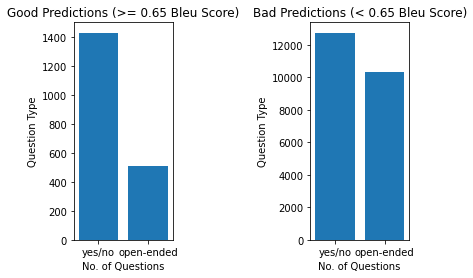

In [30]:
#Fetching unique value counts for Good predictions
x = good_pred.questionType.value_counts()
plt.subplot(1, 3, 1)

#Plotting No. of questions Vs questionType
plt.bar(x.index, x.values)
plt.title('Good Predictions (>= 0.65 Bleu Score)')
plt.xlabel('No. of Questions')
plt.ylabel('Question Type')

#Fetching unique value counts for Bad predictions
x = bad_pred.questionType.value_counts()
plt.subplot(1, 3, 3)

#Plotting No. of questions Vs questionType
plt.bar(x.index, x.values)
plt.title('Bad Predictions (< 0.65 Bleu Score)')
plt.xlabel('No. of Questions')
plt.ylabel('Question Type')

plt.show()

* The model correctly predicts answers for more yes/no type of questions than Open ended questions.


#### Predictions by Question Word Count

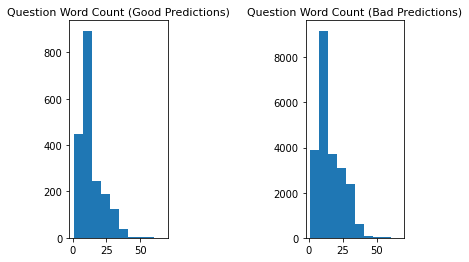

In [31]:
# Histogram of Question Word Count for Good predicitons
plt.subplot(1, 3, 1)
#storing word count of each question
q_len = []
for question in good_pred['question']:
    q_len.append(len(question.split()))

#Plotting Histogram
plt.hist(q_len)
plt.title("Question Word Count (Good Predictions)",fontsize=11)


# Histogram of Question Word Count for Bad predicitons
plt.subplot(1, 3, 3)
#storing word count of each question
q_len = []
for question in bad_pred['question']:
    q_len.append(len(question.split()))

#Plotting Histogram
plt.hist(q_len)
plt.title("Question Word Count (Bad Predictions)",fontsize=11)

plt.show()

* Model mostly predicts correctly for questions having word count around 10. 

#### Predictions by Answer Type

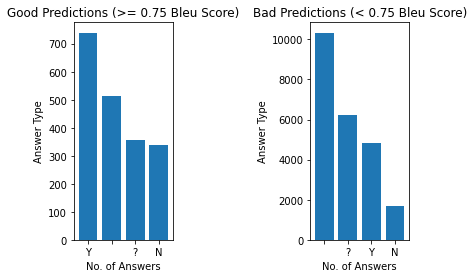

In [32]:
plt.subplot(1, 3, 1)
#Fetching unique value counts for Good predictions
x = good_pred.answerType.value_counts()

#Plotting No. of questions Vs questionType
plt.bar(x.index, x.values)
plt.title('Good Predictions (>= 0.75 Bleu Score)')
plt.xlabel('No. of Answers')
plt.ylabel('Answer Type')


plt.subplot(1, 3, 3)
#Fetching unique value counts for Bad predictions
x = bad_pred.answerType.value_counts()

#Plotting No. of questions Vs questionType
plt.bar(x.index, x.values)
plt.title('Bad Predictions (< 0.75 Bleu Score)')
plt.xlabel('No. of Answers')
plt.ylabel('Answer Type')

plt.show()

* Model predicts correctly more for yes type of answers.


#### Predictions by Answer Word Count

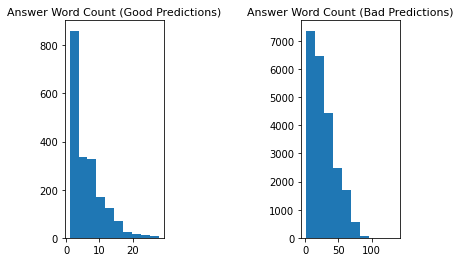

In [33]:
#plt.xlim(0,300)
#plt.xticks(range(0,350,10))

# Histogram of Answer Word Count for Good predicitons
plt.subplot(1, 3, 1)
#storing word count of each question
a_len = []
for question in good_pred['answer']:
    a_len.append(len(question.split()))
#Plotting Histogram
plt.hist(a_len)
plt.title("Answer Word Count (Good Predictions)",fontsize=11)


# Histogram of Question Word Count for Bad predicitons
plt.subplot(1, 3, 3)
#storing word count of each question
a_len = []
for question in bad_pred['answer']:
    a_len.append(len(question.split()))
#Plotting Histogram
plt.hist(a_len)
plt.title("Answer Word Count (Bad Predictions)",fontsize=11)

plt.show()

* More Short answers (i.e. less than 10 words) are correctly predicted by the model as compared to long answers.

#### Predictions by Product Category

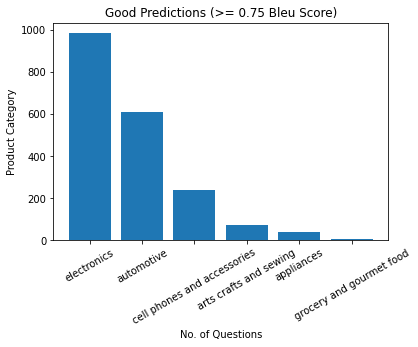

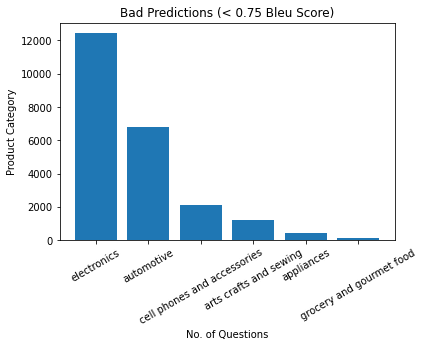

In [34]:
#Fetching unique value counts
x = good_pred.category.value_counts()
#Plotting No. of questions Vs questionType
plt.bar(x.index, x.values)
plt.xticks(rotation=30)
plt.title('Good Predictions (>= 0.75 Bleu Score)')
plt.xlabel('No. of Questions')
plt.ylabel('Product Category')
plt.show()

#Fetching unique value counts
x = bad_pred.category.value_counts()
#Plotting No. of questions Vs questionType
plt.bar(x.index, x.values)
plt.xticks(rotation=30)
plt.title('Bad Predictions (< 0.75 Bleu Score)')
plt.xlabel('No. of Questions')
plt.ylabel('Product Category')

plt.show()

* Product category does not tell much about good or bad predictions.

#### Predictions by Product's Main Category

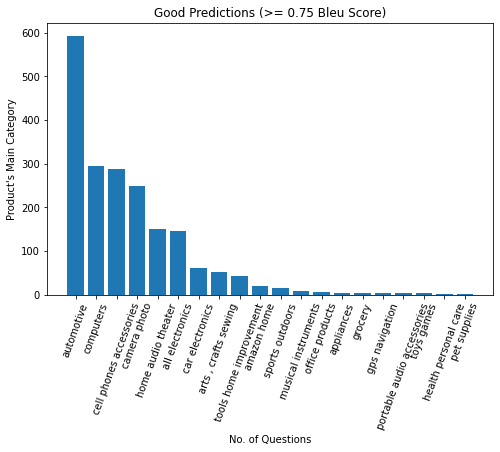

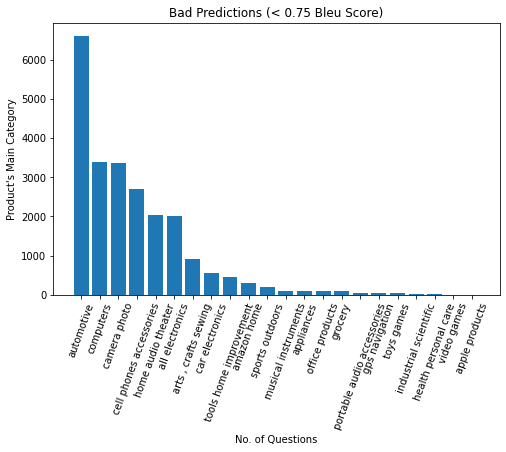

In [35]:
#Fetching unique value counts
x = good_pred.main_cat.value_counts()
plt.figure(figsize=(8,5))
#Plotting No. of questions Vs questionType
plt.bar(x.index, x.values)
plt.xticks(rotation=70)
plt.title('Good Predictions (>= 0.75 Bleu Score)')
plt.xlabel('No. of Questions')
plt.ylabel('Product\'s Main Category')


#Fetching unique value counts
x = bad_pred.main_cat.value_counts()
plt.figure(figsize=(8,5))
#Plotting No. of questions Vs questionType
plt.bar(x.index, x.values)
plt.xticks(rotation=70)
plt.title('Bad Predictions (< 0.75 Bleu Score)')
plt.xlabel('No. of Questions')
plt.ylabel('Product\'s Main Category')
plt.show()

* Product's main category does not tell much about good or bad predictions.

###Summary :

* The Model Predicts better for Yes/No type of questions rather than open-ended questions. 
* Short Answers having word count less than 10 words are more often correctly predcited by the model as compared to long answers.
* Good Predictions also have more no. of questions which have yes as answer instead of any other answer type.
* Good or Bad Predictions does not depend on product category.

**Note:**
* Predictions having BLEU score of >=0.65 are considered as Good /Correct Predictions.
* Predictions having BLEU score of <0.65 are considered as Bad Predictions.